# Homework 5 - Rasch Models Three Ways

due Friday, April 14th by 5:00 pm.

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc as pm
import arviz as az
import patsy
import re
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc, roc_curve

Key note (remove before submission)
For the sake of identifiability we will always assume that the distributions of abilities will have a mean of 0 while difficulties do not. Keep this in mind when constructing your model(s) and interpreting your results.

## Task 1 - Data Cleaning

In [2]:
df = pd.read_csv("data/exam.csv")

In [3]:
# Melt first
df_melted = df.melt(id_vars = ['id'], var_name = 'question_id')
df_melted['question_id'] = df_melted['question_id'].apply(lambda x: int(re.findall("\d+", x)[0])) #turning into integer
df_melted = df_melted.rename(columns={'id': 'student_id', 'value': 'correct'})

In [4]:
# Then, split data into train and test sets
train_df_melted, test_df_melted = train_test_split(df_melted, test_size=0.2, random_state=413)

In [5]:
print (len(train_df_melted.student_id.unique()))
print (len(train_df_melted.question_id.unique()))

200
20


In [6]:
print (len(test_df_melted.student_id.unique()))
print (len(test_df_melted.question_id.unique()))

200
20


## Task 2 - Basic EDA

* What is the average *difficulty* of the questions in these data?

In [126]:
difficulties = train_df_melted[["question_id", "correct"]].groupby("question_id").mean()
difficulties.mean()["correct"].mean()

0.6015752516395809

* What was the hardest question based on these data?

In [127]:
print("Question Number:", difficulties["correct"].idxmin(), "| Proportion Correct:", difficulties["correct"].min())

Question Number: 14 | Proportion Correct: 0.15527950310559005


Question 14, as the fewest number of students got it right.

* Which student had the highest ability based on these data?

In [141]:
sumability = train_df_melted[["student_id", "correct"]].groupby("student_id").sum()
sumability["std_ability"] = (sumability["correct"] - sumability["correct"].mean()) / sumability["correct"].std()
sumability[sumability.std_ability == max(sumability.std_ability)]

,correct,std_ability
student_id,,
27962911,17,2.344907
43108809,17,2.344907
67563036,17,2.344907


The student IDs 27962911, 43108809, and 67563036 all had the highest ability (2.34 std deviations above the mean).

## Task 3 - Logistic Regression

In [7]:
train_df_melted

,student_id,question_id,correct
3589,93180594,18,1
1009,4253054,6,1
2988,93120209,15,0
1868,34300888,10,1
510,56830317,3,0
...,...,...,...
3726,65115107,19,1
568,84941703,3,1
2842,20502604,15,0
1798,98708546,9,0


In [10]:
from patsy import dmatrices
logistic_train_y, logistic_train_X = dmatrices('correct ~ C(question_id) + C(student_id)', train_df_melted, return_type = 'dataframe')

In [11]:

logistic_model = sm.Logit(logistic_train_y, logistic_train_X)

In [15]:
logistic_ret = logistic_model.fit()

         Current function value: 0.468569
         Iterations: 35


/usr/local/lib64/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
print(logistic_ret.summary())

                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                 3200
Model:                          Logit   Df Residuals:                     2981
Method:                           MLE   Df Model:                          218
Date:                Thu, 13 Apr 2023   Pseudo R-squ.:                  0.3026
Time:                        20:06:43   Log-Likelihood:                -1499.4
converged:                      False   LL-Null:                       -2149.9
Covariance Type:            nonrobust   LLR p-value:                1.878e-153
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.5344      0.685      5.157      0.000       2.191       4.878
C(question_id)[T.2]          -0.6507      0.337     -1.931      0.054      -1.311     

In [33]:
logistic_student_id_coef = logistic_ret.params[20:220]
logistic_student_id_coef

C(student_id)[T.930606]     -0.632054
C(student_id)[T.1148681]    -0.411284
C(student_id)[T.1394545]    -2.335001
C(student_id)[T.2154380]    -0.765481
C(student_id)[T.2729499]    -2.395735
                               ...   
C(student_id)[T.97083085]    0.290021
C(student_id)[T.97922021]    0.162621
C(student_id)[T.98426725]   -1.661221
C(student_id)[T.98708546]   -1.016380
C(student_id)[T.99534243]   -1.150003
Length: 199, dtype: float64

In [61]:
temp_mean = logistic_student_id_coef.mean()

* What is the average *difficulty* of the questions in this model?

In [21]:
logistic_question_id_coef = logistic_ret.params[0:20]
logistic_question_id_coef

Intercept               3.534364
C(question_id)[T.2]    -0.650701
C(question_id)[T.3]    -2.155282
C(question_id)[T.4]    -3.513993
C(question_id)[T.5]    -2.831919
C(question_id)[T.6]    -1.960788
C(question_id)[T.7]     0.957785
C(question_id)[T.8]    -2.646471
C(question_id)[T.9]    -2.234814
C(question_id)[T.10]   -1.765815
C(question_id)[T.11]   -3.107373
C(question_id)[T.12]   -1.091270
C(question_id)[T.13]   -1.369495
C(question_id)[T.14]   -4.464092
C(question_id)[T.15]   -1.093458
C(question_id)[T.16]   -2.405403
C(question_id)[T.17]   -2.992538
C(question_id)[T.18]    0.680850
C(question_id)[T.19]    0.872431
C(question_id)[T.20]   -1.575428
dtype: float64

In [64]:
correct_prob = []

for idx, coef in enumerate(logistic_question_id_coef):
    if idx == 0:
        odds_ratio = np.exp(coef + temp_mean)
    else: 
        odds_ratio = np.exp(logistic_question_id_coef[0] + coef + temp_mean)
    correct_prob.append(odds_ratio / (1 + odds_ratio))
    

correct_prob

[0.917894231557598,
 0.8536316404053941,
 0.5643391955015554,
 0.24975500528287875,
 0.3970323922475402,
 0.6114203115522843,
 0.9668133797260181,
 0.4421608468675832,
 0.5446954426081027,
 0.6566179189659603,
 0.3332995246485401,
 0.7896477425323233,
 0.7397324916415887,
 0.11405057922829764,
 0.78928419534181,
 0.502167725270735,
 0.3592861794330341,
 0.9566828701005105,
 0.9639629249264765,
 0.6981798646324393]

In [65]:
print(np.mean(correct_prob))

0.6225327231235336


* What was the hardest question based on this model?

In [32]:
print(np.argmin(correct_prob) + 1)

14


* Which student had the highest ability based on this model?

In [71]:
print(np.argmax(logistic_student_id_coef) )

30


In [46]:
dict = dict(logistic_ret.params)

In [73]:
list(dict.keys())[20 + 30]

'C(student_id)[T.13411641]'

## Task 4 - Mixed Effects 

You can completely ignore the Bayesian aspect of this model and simply use the posterior means of all model parameters / coefficients.

In [55]:
# Fit the model using statsmodels
# Fit mixed effects model
import statsmodels.genmod.bayes_mixed_glm as smgb

model_formula = 'correct ~ C(question_id)' 
random_effect = {"student_id": '0 + C(student_id)'}
model = smgb.BinomialBayesMixedGLM.from_formula(model_formula, random_effect, train_df_melted)

# obtain an approximate fit using the fit_vb method
result = model.fit_vb()

In [56]:
# summarize the model results
print(result.summary())

                    Binomial Mixed GLM Results
                     Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
-------------------------------------------------------------------
Intercept               M     1.8039   0.0429                      
C(question_id)[T.2]     M    -0.2483   0.1979                      
C(question_id)[T.3]     M    -1.6235   0.1726                      
C(question_id)[T.4]     M    -2.8652   0.1864                      
C(question_id)[T.5]     M    -2.2507   0.1714                      
C(question_id)[T.6]     M    -1.4371   0.1703                      
C(question_id)[T.7]     M     1.2501   0.3289                      
C(question_id)[T.8]     M    -2.0608   0.1700                      
C(question_id)[T.9]     M    -1.6705   0.1699                      
C(question_id)[T.10]    M    -1.2669   0.1743                      
C(question_id)[T.11]    M    -2.4755   0.1753                      
C(question_id)[T.12]    M    -0.6382   0.1847                      
C

* What is the average *difficulty* of the questions in this model?

In [57]:
question_id_coef = result.params[0:20]
question_id_coef

array([ 1.80393921, -0.24827511, -1.62347377, -2.86518425, -2.25065392,
       -1.43714024,  1.2501492 , -2.06081655, -1.67053258, -1.26691679,
       -2.47553296, -0.63816077, -0.88521938, -3.7266253 , -0.64958762,
       -1.86397311, -2.39620294,  0.98764137,  1.16630621, -1.11135202])

In [58]:
correct_prob = []

for idx, coef in enumerate(question_id_coef):
    if idx == 0:
        odds_ratios = np.exp(coef)
    else: 
        odds_ratios = np.exp(result.params[0] + coef)
    correct_prob.append(odds_ratios / (1 + odds_ratios))

correct_prob

[0.8586277760904188,
 0.825730298981406,
 0.5449943117228075,
 0.257071596766265,
 0.39014215611513586,
 0.5906852709150775,
 0.9549587069122889,
 0.43613148077174896,
 0.5333022818476212,
 0.6311194849772708,
 0.338140065922715,
 0.7623811003289359,
 0.7147811889871387,
 0.12756233184873195,
 0.7603048541466594,
 0.4849960306880919,
 0.3561156170831007,
 0.9422191550284608,
 0.9512116676975327,
 0.6665422113505517]

In [59]:
print(np.mean(correct_prob))

0.6063508794090979


* What was the hardest question based on this model?

In [ ]:
# Find hardest question
# hardest_question = odds_ratios.idxmax()

* Which student had the highest ability based on this model?

In [60]:
# Calculate student abilities
student_abilities = train_df_melted.groupby('student_id')['correct'].mean()
highest_ability_student = student_abilities.idxmax()
highest_ability_student

13411641

## Task 5 - Bayesian Model

In [116]:
task5train = pd.get_dummies(train_df_melted, columns = ["student_id", "question_id"])
y_train = task5train["correct"]
X_train = task5train[task5train.columns[1:221]]

In [117]:
students = sorted(train_df_melted["student_id"].unique())
questions = sorted(train_df_melted["question_id"].unique())

In [118]:
coord = {'student':students, 'question':questions}
with pm.Model(coords = coord) as model:
    # data containers
    X = pm.MutableData("X", X_train)
    y = pm.MutableData("y", y_train)
    # priors
    a = pm.Normal("a", mu=0, sigma=3, dims="student")
    h = pm.Normal('h', mu = 0, sigma = 3)
    b = pm.Normal("b", mu=h, sigma=3, dims="question")
    # linear model
    mu = X[:, 0:200] @ a + X[:, 200:220] @ b
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    obs = pm.Bernoulli("obs", p=p, observed=y)

#### Fitting

In [119]:
with model:
    post = pm.sample(progressbar=False, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, h, b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [135]:
table = az.summary(post)
studentsout = table["mean"][0:200]
questionsout = table["mean"][201:221]

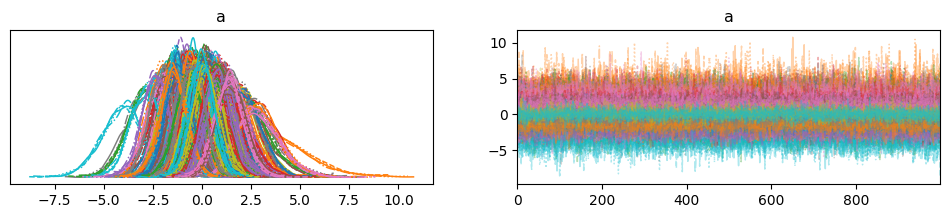

In [136]:
#Include some basic diagnostics showing that the model converged.
ax = az.plot_trace(post, var_names="a", compact=True)
plt.show()

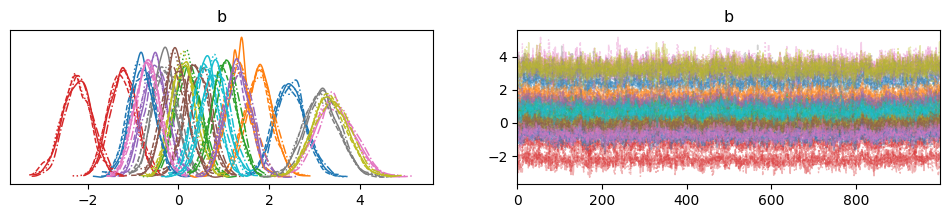

In [137]:
ax = az.plot_trace(post, var_names="b", compact=True)
plt.show()

Looking at the trace plots, it appears that the model converged (hairy caterpillars)

* What is the average *difficulty* of the questions in this model?

In [138]:
questionsout.mean()

0.70775

* What was the hardest question based on these this model?

In [139]:
questionsout.idxmin()

'b[14]'

* Which student had the highest ability based on these this model?

In [140]:
studentsout.sort_values(ascending = False)[0:5]

a[13411641]    3.806
a[85701846]    2.993
a[31234385]    2.977
a[76415409]    2.900
a[88368804]    2.884
Name: mean, dtype: float64

Student 13411641 had the highest ability.

## Task 6 - Comparison

The average difficulty is between 0.6 and 0.7 for all models. The hardest question is consistently Q14. Student ID 13411641 appears to be the student with the highest ability in most of the models (or prominent on the list of top students).

## Task 7 - Evaluation

### Logistic Model

In [66]:
from patsy import dmatrices
logistic_test_y, logistic_test_X = dmatrices('correct ~ C(question_id) + C(student_id)', test_df_melted, return_type = 'dataframe')

In [69]:
logistic_pred_y = logistic_ret.predict(logistic_test_X)


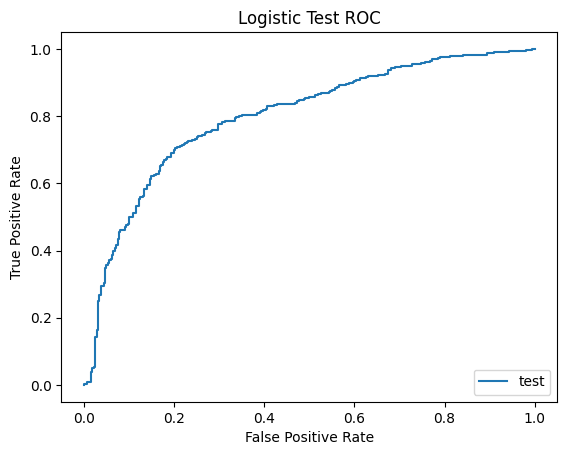

In [70]:
fpr_test, tpr_test, thd_test = roc_curve(logistic_test_y, logistic_pred_y)
auc_test = auc(fpr_test, tpr_test); auc_test

fig, ax = plt.subplots()
roc = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test).plot(ax=ax, label="test")
ax.set_title("Logistic Test ROC")
plt.show()

### Bayesian Model

In [120]:
task5test = pd.get_dummies(test_df_melted, columns = ["student_id", "question_id"])
y_test = task5test["correct"].to_numpy()
X_test = task5test[task5test.columns[1:221]].to_numpy()

with model:
    pm.set_data({"X": X_test, "y": y_test})
    post = pm.sample_posterior_predictive(
        post, progressbar=False, var_names=["obs", "p"],
        extend_inferencedata = True
)

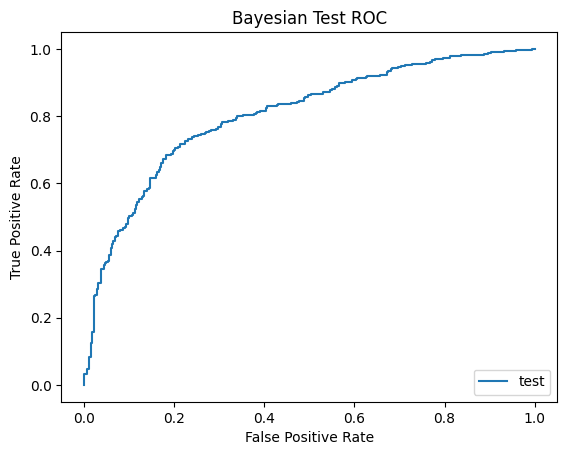

In [144]:
# Test data
p_test  = post.posterior_predictive["p"].mean(dim=["chain", "draw"])
fpr_test, tpr_test, thd_test = roc_curve(y_true=y_test, y_score=p_test)
auc_test = auc(fpr_test, tpr_test); auc_test

fig, ax = plt.subplots()
roc = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test).plot(ax=ax, label="test")
ax.set_title("Bayesian Test ROC")
plt.show()